# BNFinder Analysis Summary

This notebook summarizes the results of the BNFinder experiments, identifying how different dataset parameters affect network recovery and attractor identification, separated by network dimensionality.

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 12

In [37]:
# Load data
report_files = glob.glob("reports/analysis_report_*.csv")

if not report_files:
    print("No analysis reports found in reports/ directory. Generating path check...")
    # Fallback/Debug check
    if os.path.exists('analysis/reports'):
         report_files = glob.glob("analysis/reports/analysis_report_*.csv")

dfs = []
for f in report_files:
    try:
        df_temp = pd.read_csv(f)
        dfs.append(df_temp)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(df)} rows from {len(dfs)} reports.")
    # Ensure dim is treated as numeric
    df.sort_values(by="dim", inplace=True)
    
    # Metrics to analyze
    metrics = ["F1", "Attractors_F1", "Transition_Accuracy"]
    
    # Ensure metrics exist, fill NaN with 0
    for m in metrics:
        if m in df.columns:
            df[m] = df[m].fillna(0)
        else:
            df[m] = 0
            
    display(df.head())
else:
    print("No data loaded.")
    df = pd.DataFrame()

Loaded 39880 rows from 22 reports.


,dim,id,mode,freq,size,len,attr_ratio,score,TP,FP,...,Recall,F1,Transition_Accuracy,Attractors_Correct,Attractors_True_Count,Attractors_Learned_Count,Attractors_Precision,Attractors_Recall,Attractors_F1,filename
0,5,4,async,3,20,10,0.0,MDL,5,7,...,0.625000,0.500000,0.650,0,1,3,0.000000,0.000000,0.000000,5d_004_async_f3_s20_l10_at0.0_scrMDL.bif
4372,5,1,sync,1,50,10,0.7,MDL,3,0,...,0.272727,0.428571,0.625,2,3,12,0.166667,0.666667,0.266667,5d_001_sync_f1_s50_l10_at0.7_scrMDL.bif
4371,5,1,async,1,1,50,0.7,MDL,3,5,...,0.272727,0.315789,0.600,1,2,5,0.200000,0.500000,0.285714,5d_001_async_f1_s1_l50_at0.7_scrMDL.bif
4370,5,1,sync,3,100,10,1.0,MDL,1,4,...,0.090909,0.125000,0.550,2,3,16,0.125000,0.666667,0.210526,5d_001_sync_f3_s100_l10_at1.0_scrMDL.bif
4369,5,1,async,1,10,150,0.8,MDL,7,5,...,0.636364,0.608696,0.725,2,2,7,0.285714,1.000000,0.444444,5d_001_async_f1_s10_l150_at0.8_scrMDL.bif


## 1. Overall Performance Distribution by Dimension and Mode

Visualizing the distribution of Structural F1, Attractor F1, and Transition Accuracy for each dimension, split by Sync/Async mode.

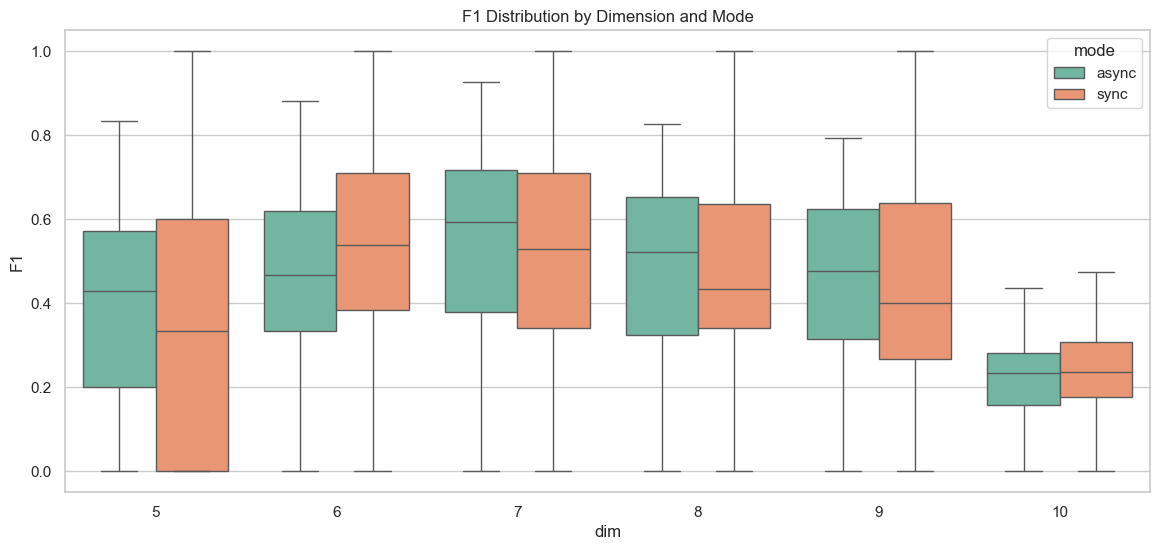

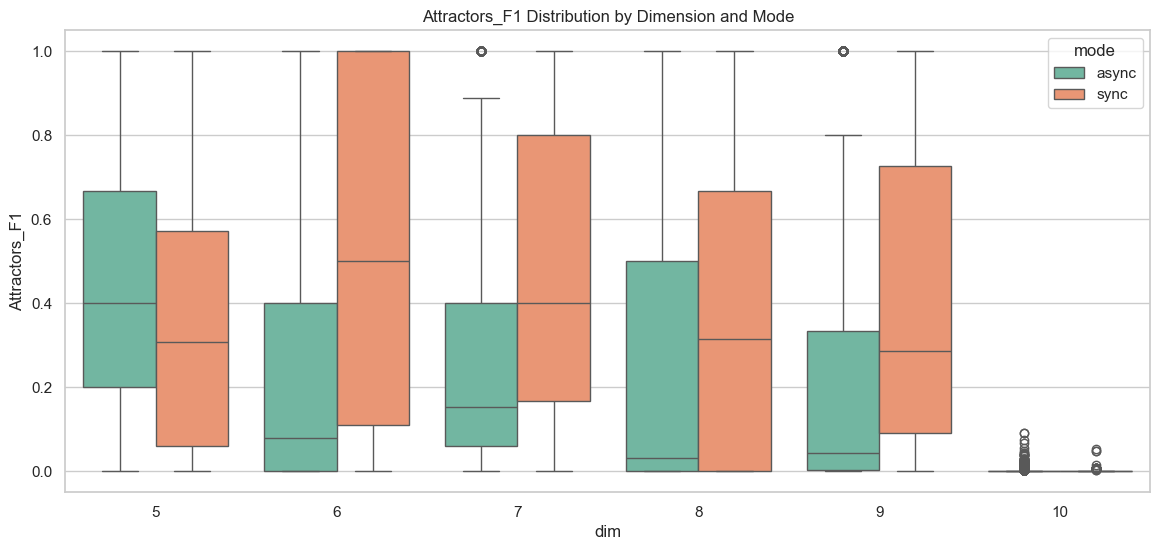

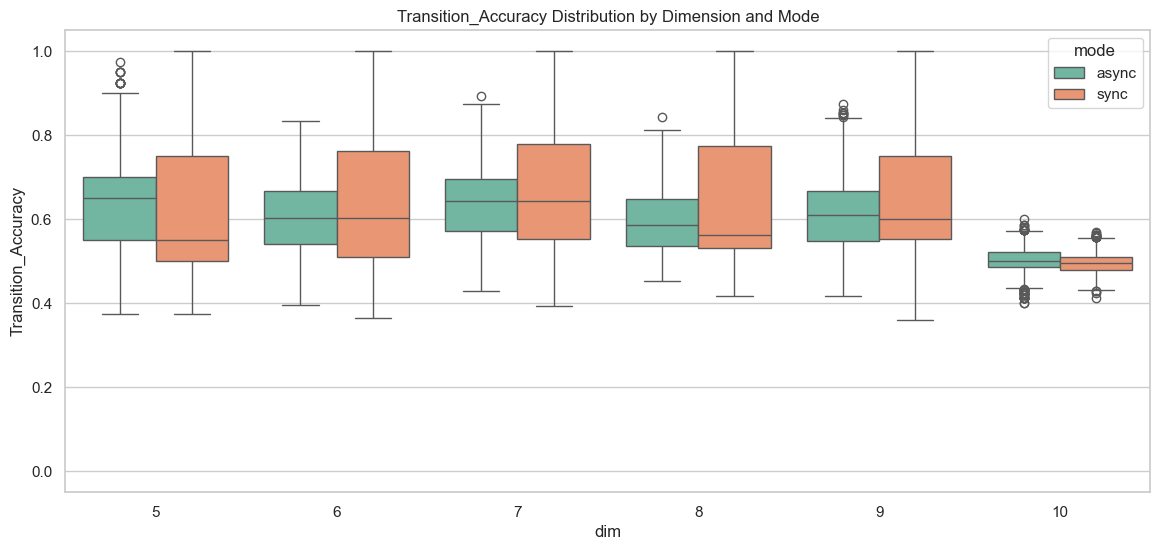

In [38]:
if not df.empty:
    for metric in metrics:
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=df, x="dim", y=metric, hue="mode", palette="Set2")
        plt.title(f"{metric} Distribution by Dimension and Mode")
        plt.ylim(-0.05, 1.05)
        plt.show()

## 2. Impact of Parameters (Controlled Analysis)

Analyzing how `size` (sample size), `freq` (sampling frequency), `attr_ratio` (attractor noise), and `audio length (len)` affect performance.
We separate plots by Dimension (`dim`) to see specific trends.


--- F1 Analysis ---


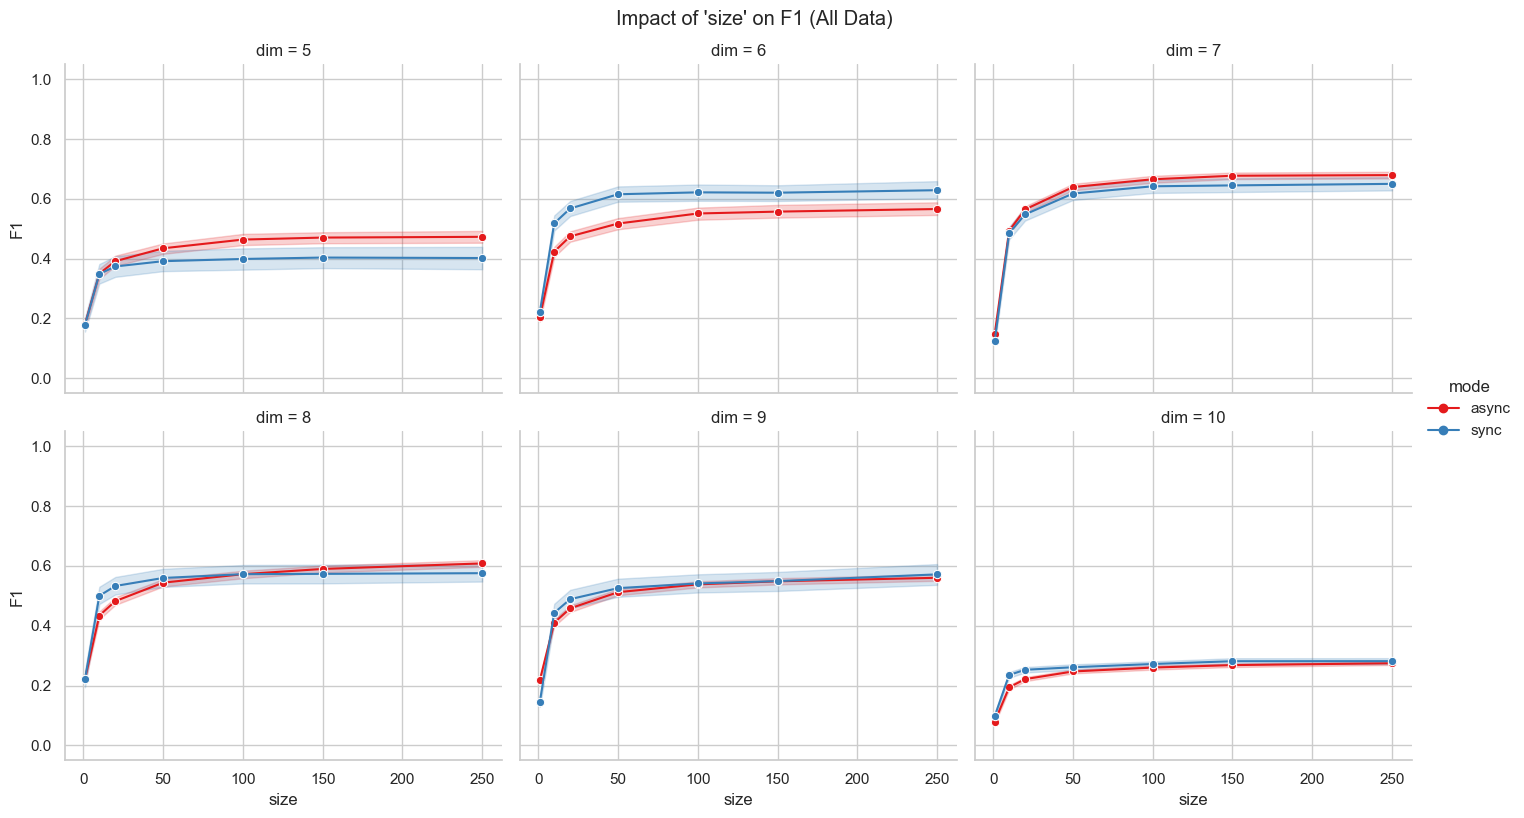

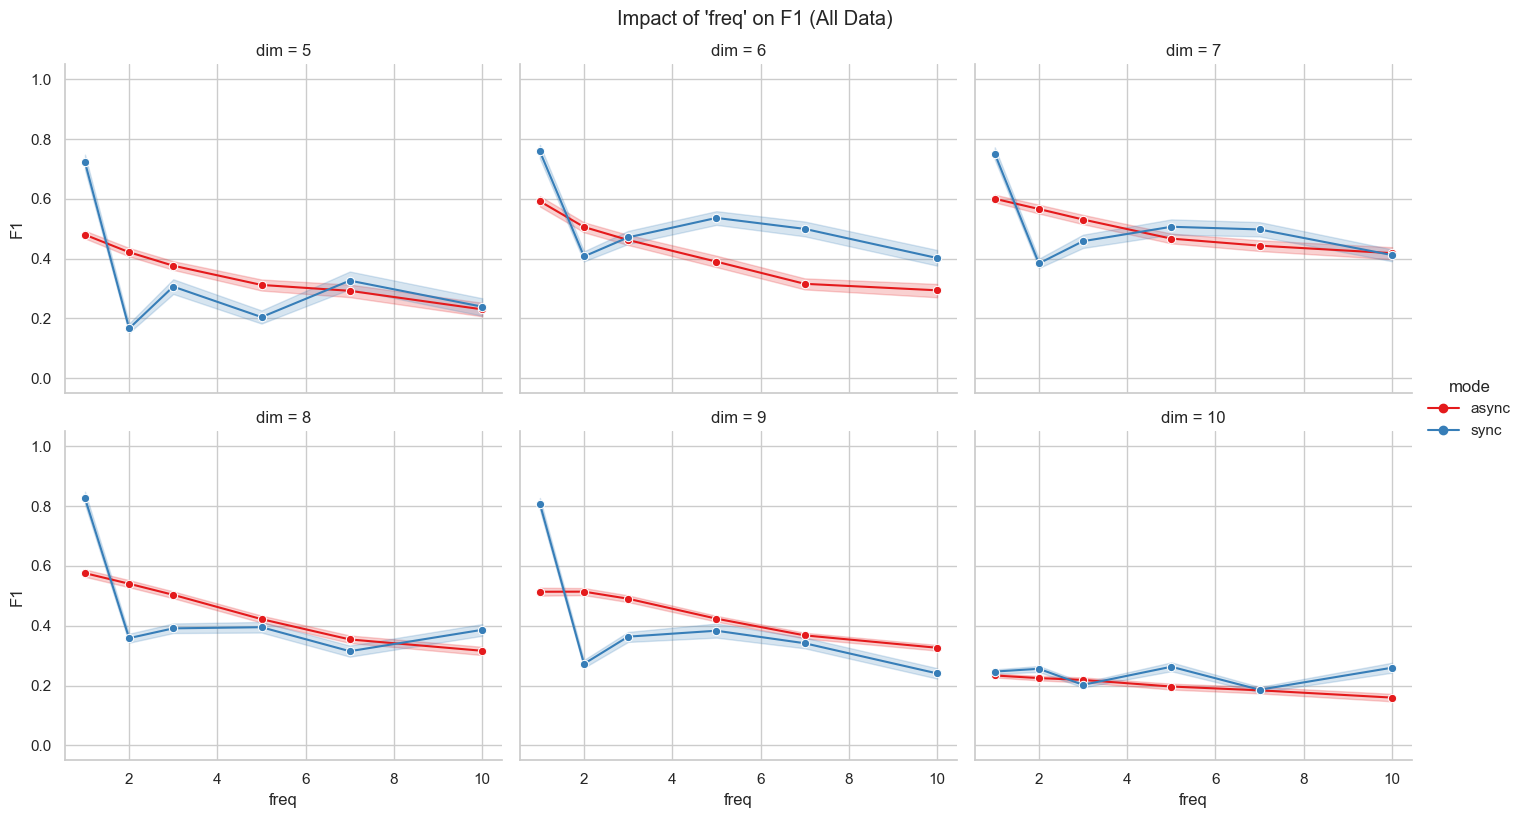

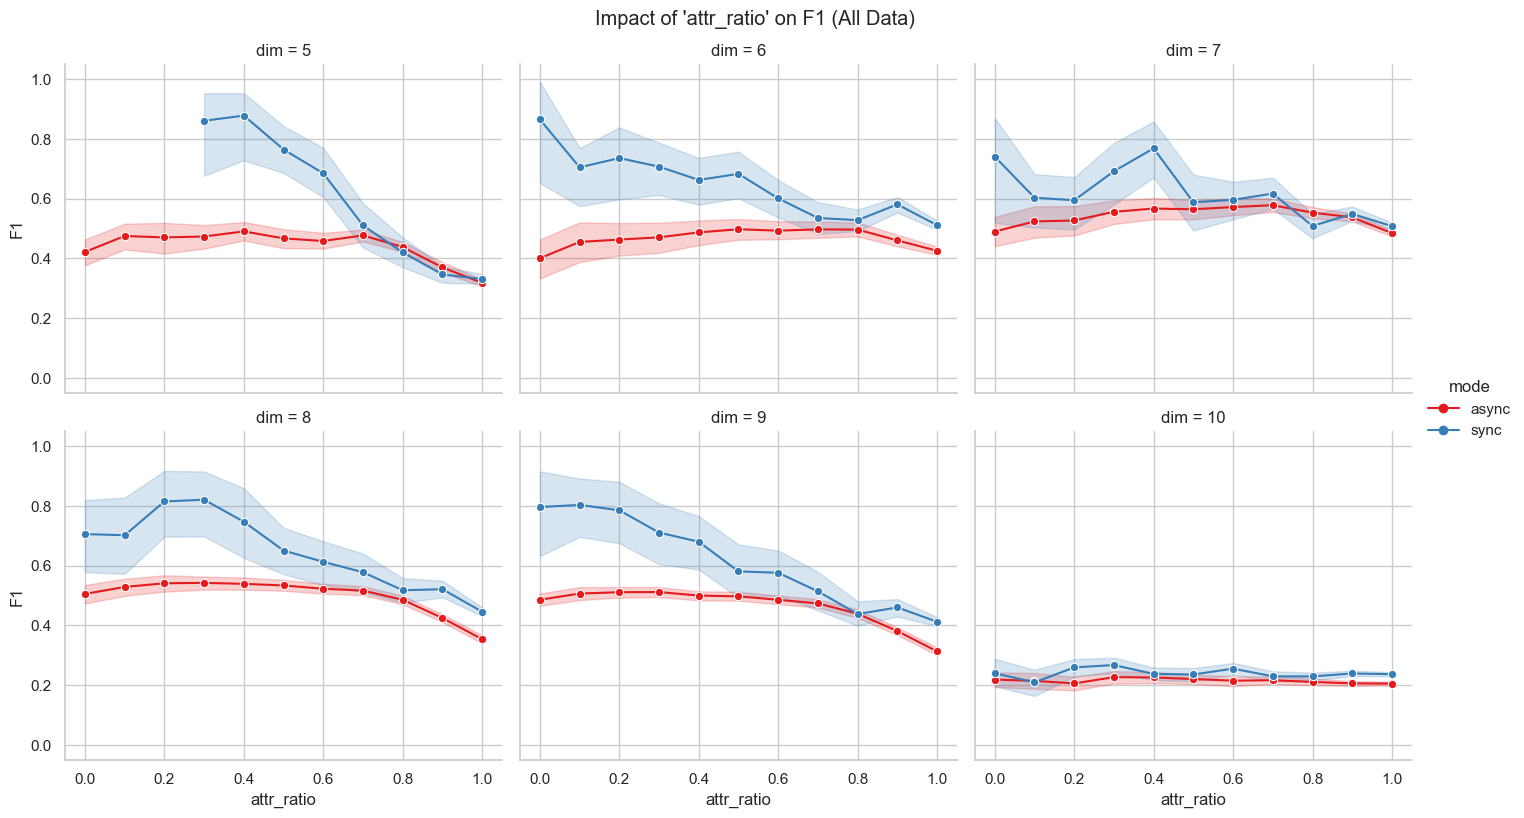

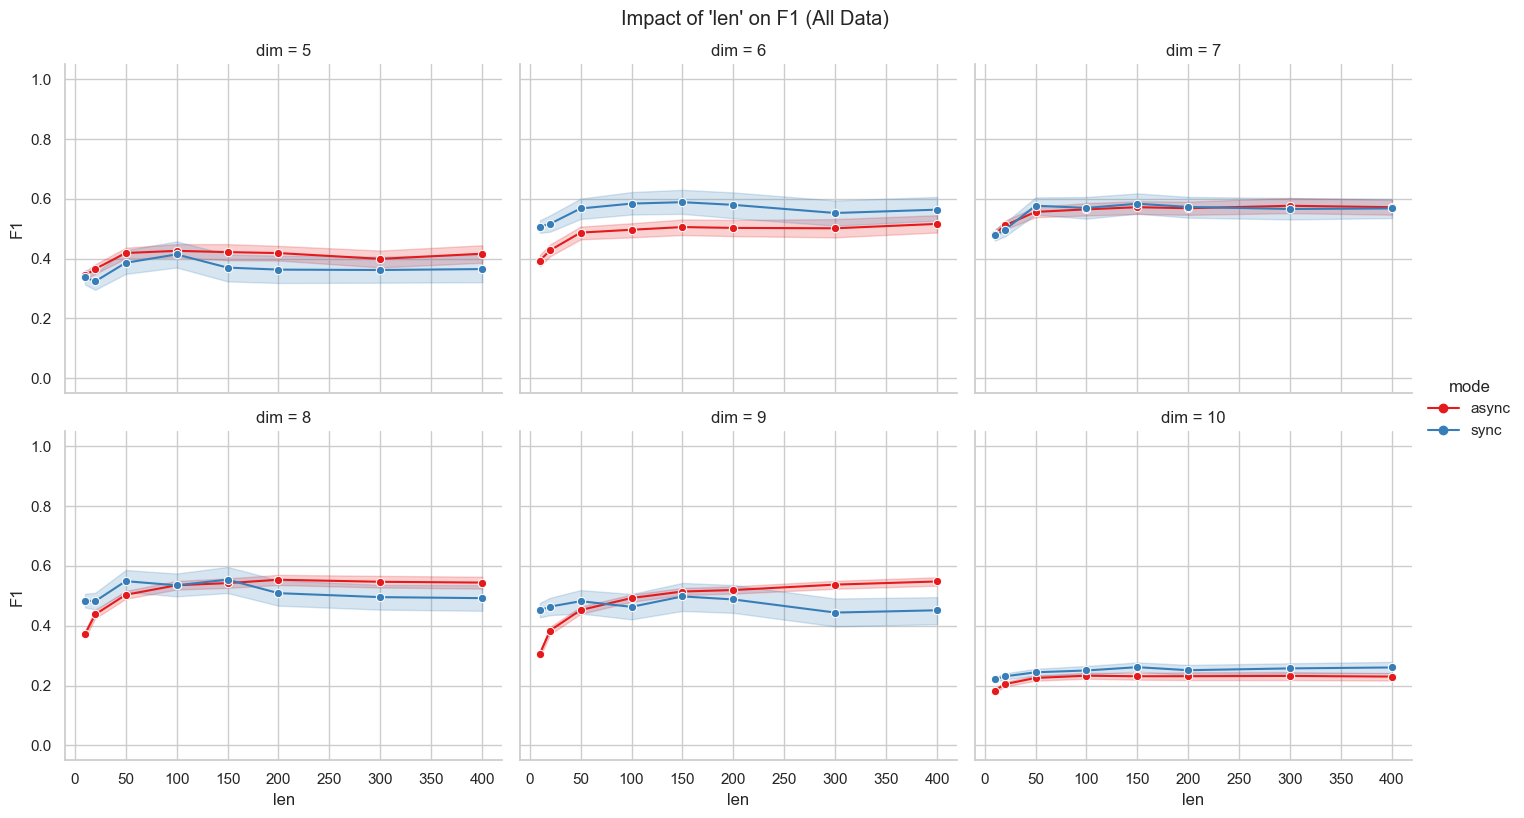


--- Attractors_F1 Analysis ---


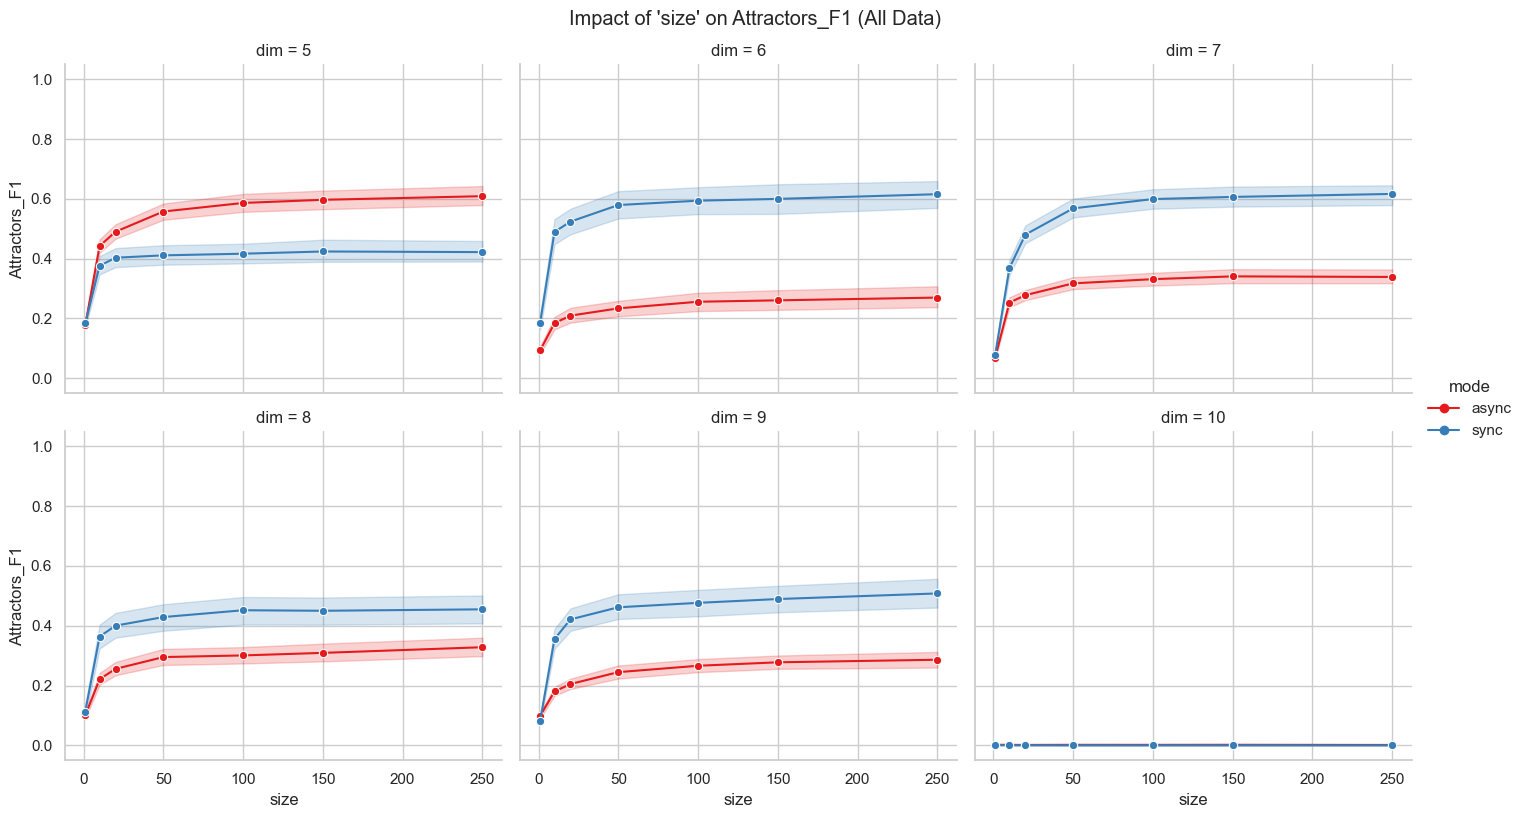

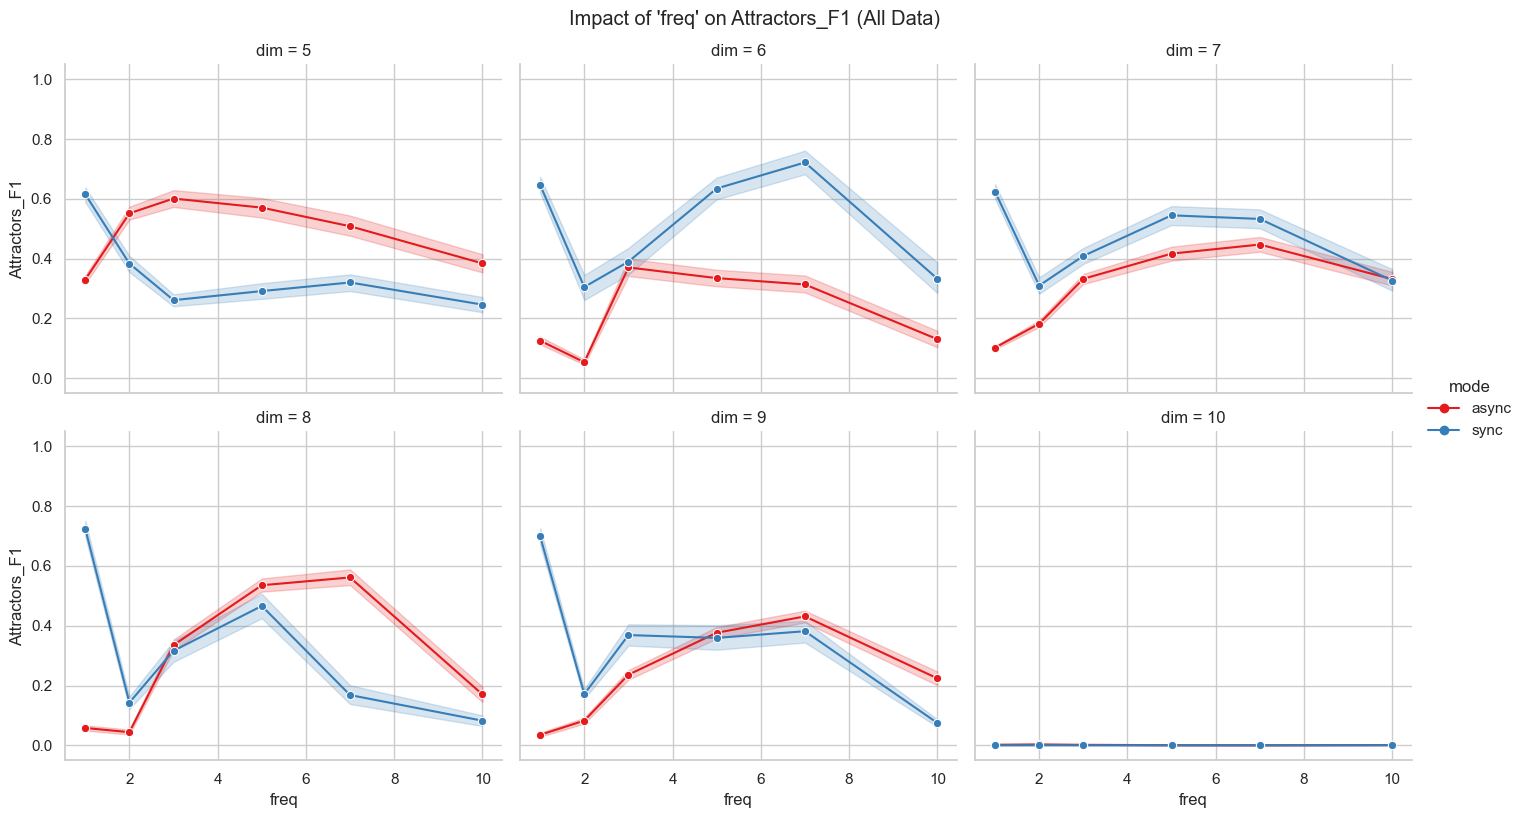

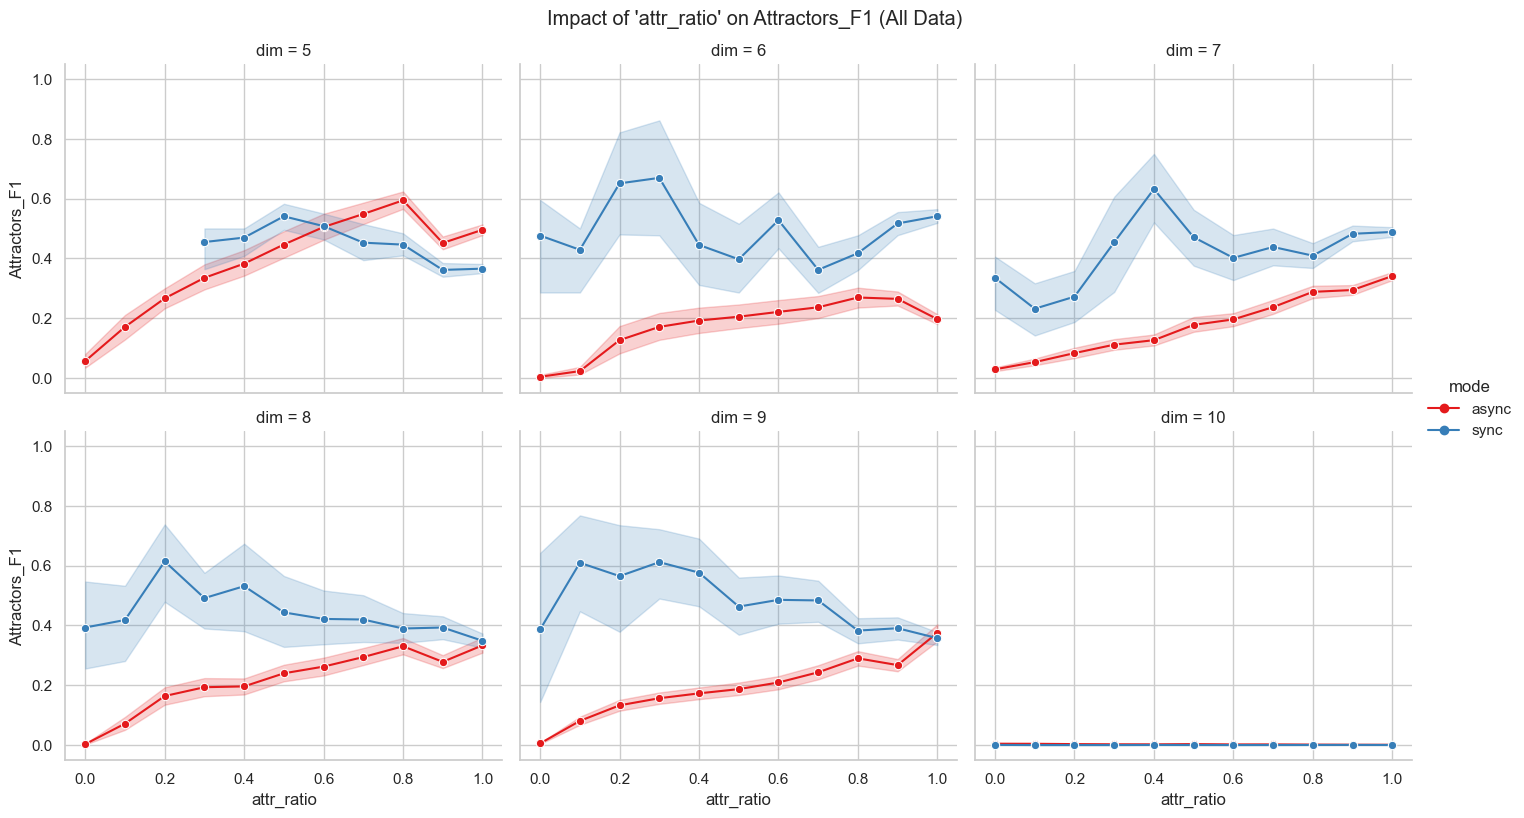

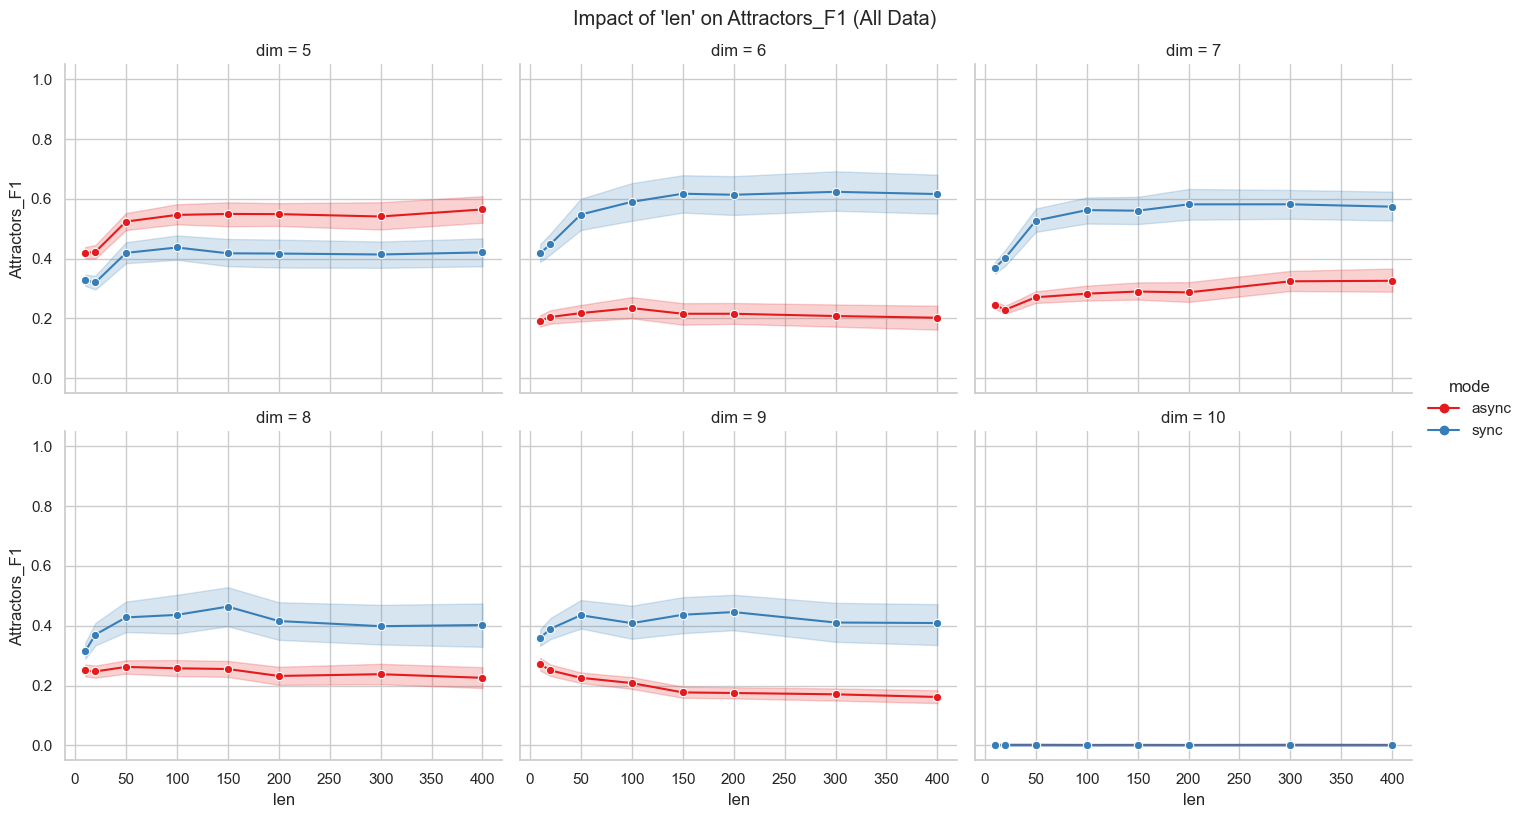


--- Transition_Accuracy Analysis ---


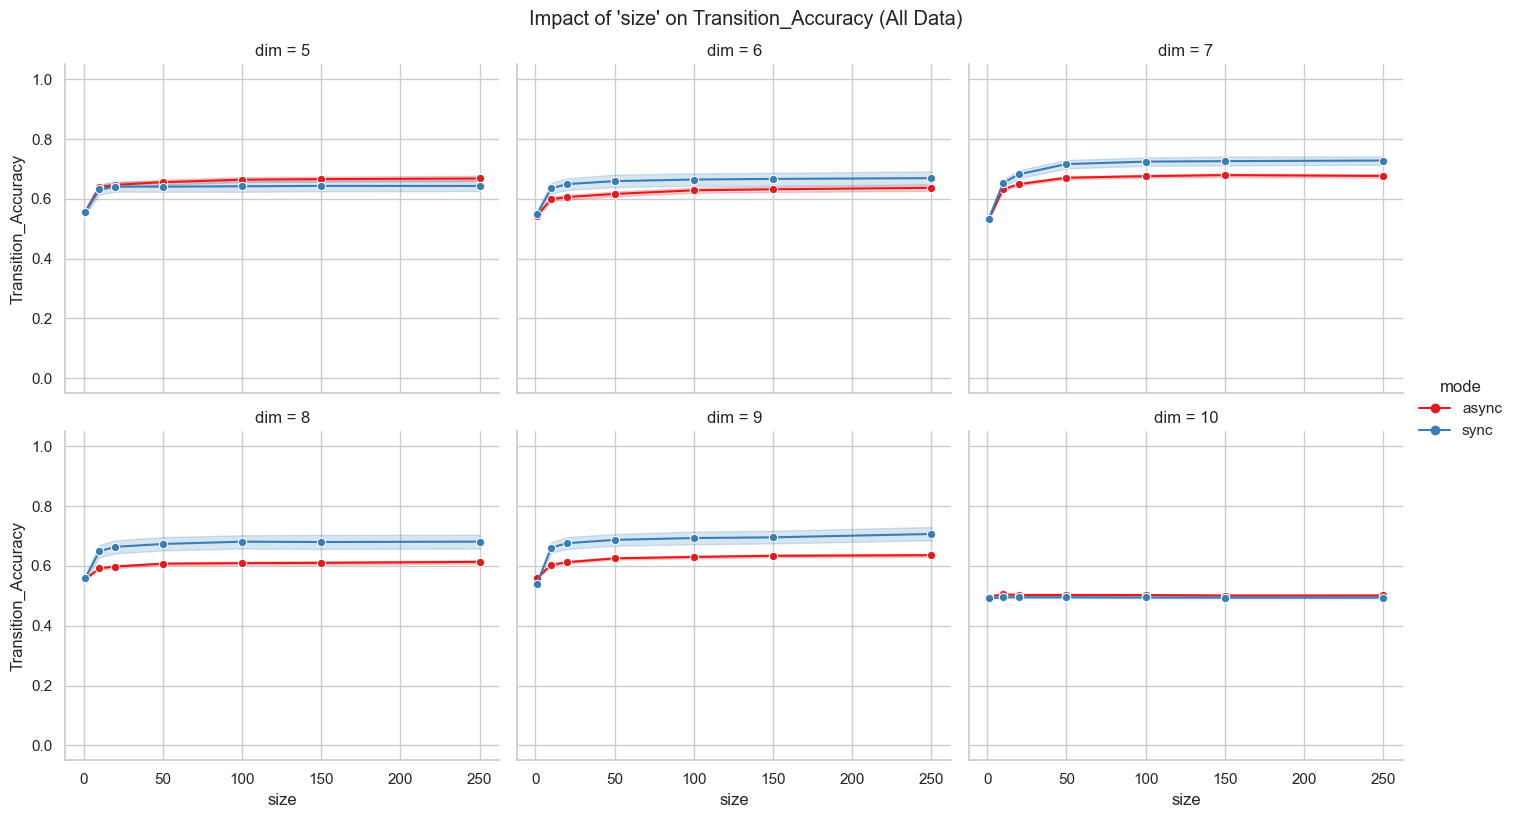

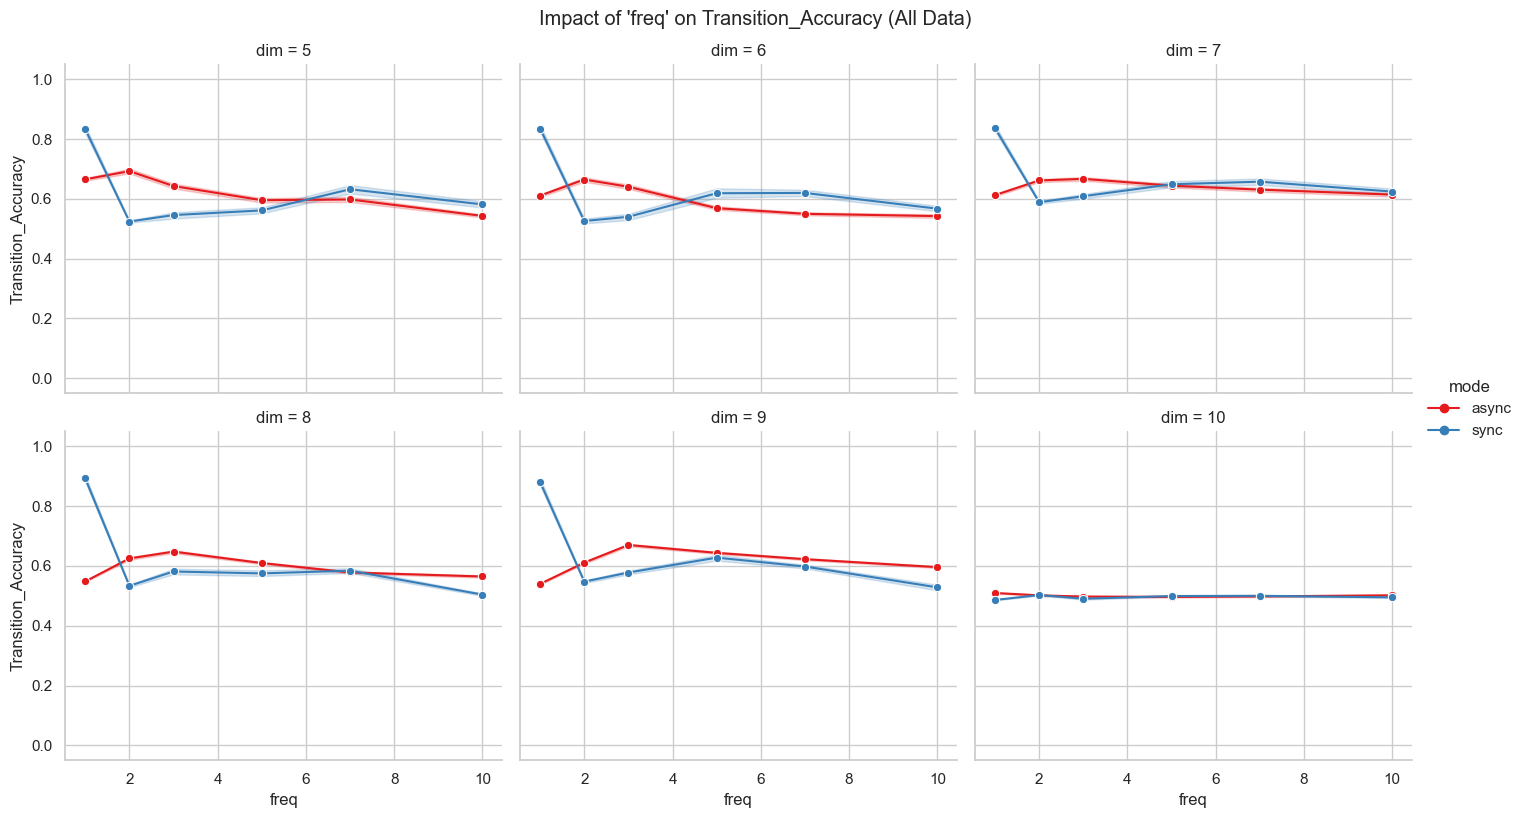

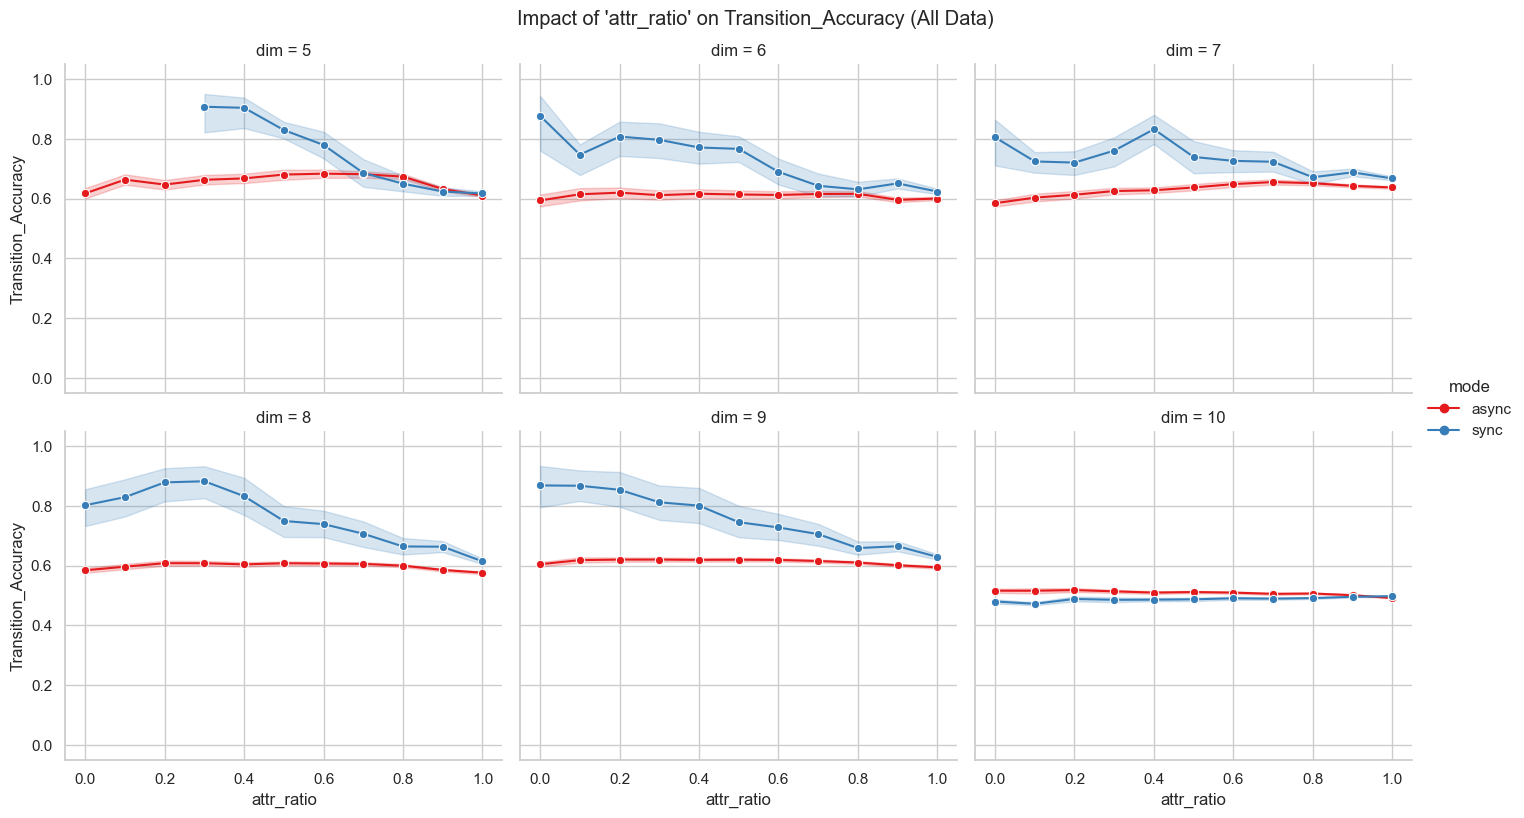

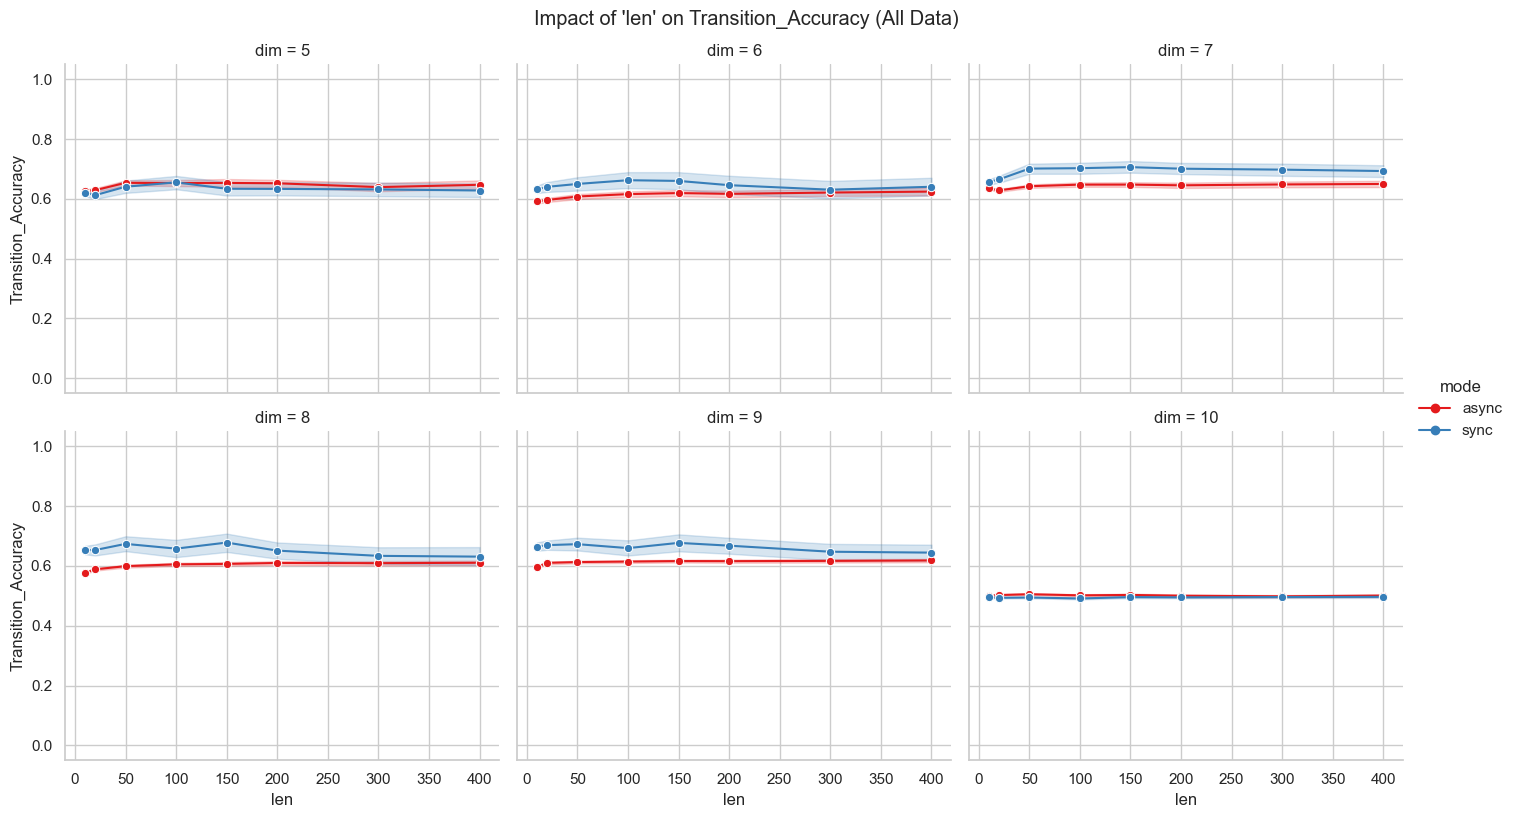

In [39]:
def plot_parameter_impact(data, param, metric, fixed_params=None):
    """
    Plots the impact of `param` on `metric`, faceted by Dimension.
    Optional `fixed_params` dict to filter data (e.g. {'len': [10, 50, 100]})
    """
    plot_df = data.copy()
    
    if fixed_params:
        title_suffix = " (Controlled: "
        for k, v in fixed_params.items():
            if k in plot_df.columns:
                plot_df = plot_df[plot_df[k].isin(v)]
                title_suffix += f"{k} in {v} "
        title_suffix += ")"
    else:
        title_suffix = " (All Data)"

    if plot_df.empty:
        print(f"No data for {param} vs {metric} with filters {fixed_params}")
        return

    # Aggregate to mean for clearer lines, but keeping scatter points is good too.
    # Here we use lineplot which automatically aggregates with confidence intervals
    g = sns.relplot(
        data=plot_df, 
        x=param, 
        y=metric, 
        hue="mode", 
        col="dim", 
        kind="line", 
        marker="o",
        col_wrap=3,
        height=4, 
        aspect=1.2,
        palette="Set1"
    )
    g.fig.suptitle(f"Impact of '{param}' on {metric}{title_suffix}", y=1.02)
    g.set(ylim=(-0.05, 1.05))
    plt.show()

if not df.empty:
    # Parameters to analyze
    params = ["size", "freq", "attr_ratio", "len"]
    
    # Controlled settings: Pin length to reasonable values for other params to reduce noise
    # (Assuming len=10, 50, 100 are common, adjust based on actual data)
    common_fixed_params = None 
    
    for metric in metrics:
        print(f"\n--- {metric} Analysis ---")

        
        # Impact of Size (fixing len to reduce variance)
        plot_parameter_impact(df, "size", metric, fixed_params=common_fixed_params)
        
        # Impact of Frequency (fixing len)
        plot_parameter_impact(df, "freq", metric, fixed_params=common_fixed_params)
        
        # Impact of Attractor Ratio
        plot_parameter_impact(df, "attr_ratio", metric, fixed_params=common_fixed_params)
        
        # Impact of Length (No filter on length itself obviously, maybe fix size/freq?)
        # Let's show all lengths aggregated
        plot_parameter_impact(df, "len", metric)

## 3. Best Configurations

Identifying the top performing configurations for each dimension and mode.

In [40]:
if not df.empty:
    # Group by Dimension and Mode
    # Find config with Max F1
    # Columns to identify config
    config_cols = ["len", "size", "freq", "attr_ratio"]
    
    print("Best Configurations by Median F1 Score:")
    
    pivot_best = df.groupby(["dim", "mode"] + config_cols)["F1"].median().reset_index()
    # For each dim/mode, pick top 1
    best_configs = pivot_best.loc[pivot_best.groupby(["dim", "mode"])["F1"].idxmax()]
    
    display(best_configs)

    print("Best Configurations by Median Transition Accuracy:")
    
    pivot_best = df.groupby(["dim", "mode"] + config_cols)["Transition_Accuracy"].median().reset_index()
    # For each dim/mode, pick top 1
    best_configs = pivot_best.loc[pivot_best.groupby(["dim", "mode"])["Transition_Accuracy"].idxmax()]
    
    display(best_configs)

Best Configurations by Median F1 Score:


,dim,mode,len,size,freq,attr_ratio,F1
444,5,async,20,50,1,0.7,0.705882
1218,5,sync,20,50,1,0.8,1.000000
1818,6,async,10,100,1,0.1,0.882353
3165,6,sync,10,50,1,0.0,1.000000
4009,7,async,10,100,2,0.2,0.829268
5143,7,sync,10,50,1,0.6,1.000000
7225,8,async,100,100,1,0.0,0.826087
8346,8,sync,10,50,1,0.8,1.000000
10057,9,async,50,100,2,0.1,0.792453
12522,9,sync,10,100,1,0.4,1.000000


Best Configurations by Median Transition Accuracy:


,dim,mode,len,size,freq,attr_ratio,Transition_Accuracy
301,5,async,10,250,2,0.6,0.862500
1373,5,sync,100,100,1,1.0,1.000000
1944,6,async,10,250,2,0.3,0.812500
3620,6,sync,150,250,1,1.0,1.000000
4433,7,async,20,250,3,0.8,0.799107
5414,7,sync,50,50,1,0.9,1.000000
5979,8,async,10,100,3,0.2,0.804688
8346,8,sync,10,50,1,0.8,1.000000
9743,9,async,20,250,3,0.1,0.805556
12522,9,sync,10,100,1,0.4,1.000000


## 4. Characteristics of Top Performers (Normalized)

We select the **top 10%** of networks (by Structural F1) *within each Dimension and Mode group* to ensure fair representation. We then visualize the distribution of parameters among these "winners", normalized as percentages to compare Sync vs Async effectively.


All Dimensions Aggregated: Analyzed 1200 Top Performers (Top 10% per Dim/Mode)


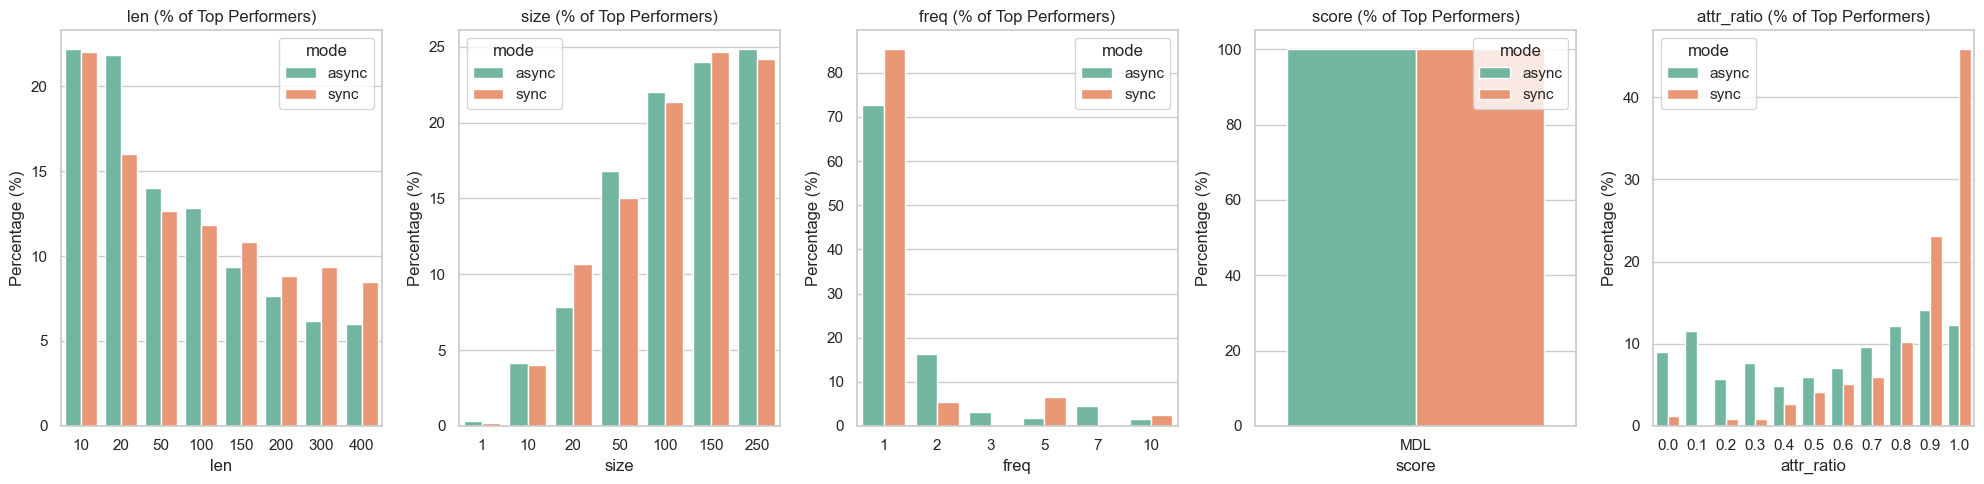


Dimension 5: Analyzed 200 Top Performers (Top 10% per Dim/Mode)


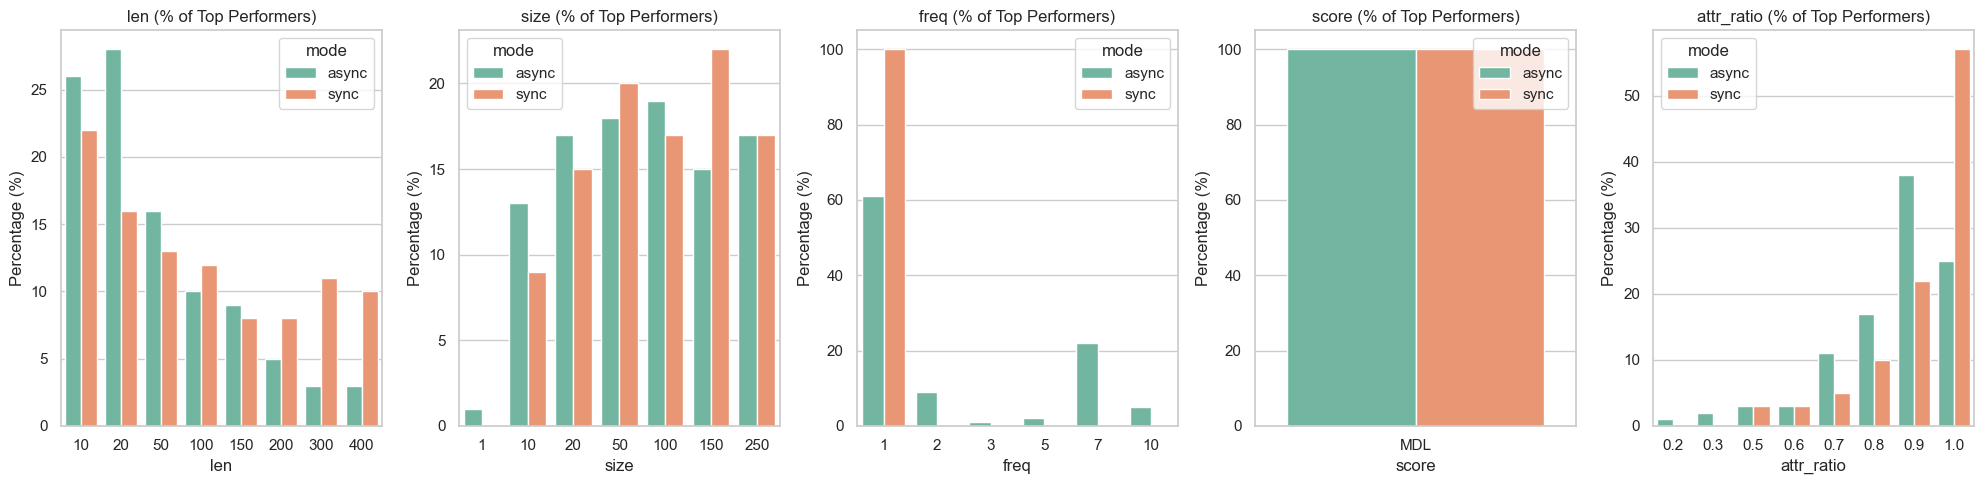


Dimension 6: Analyzed 200 Top Performers (Top 10% per Dim/Mode)


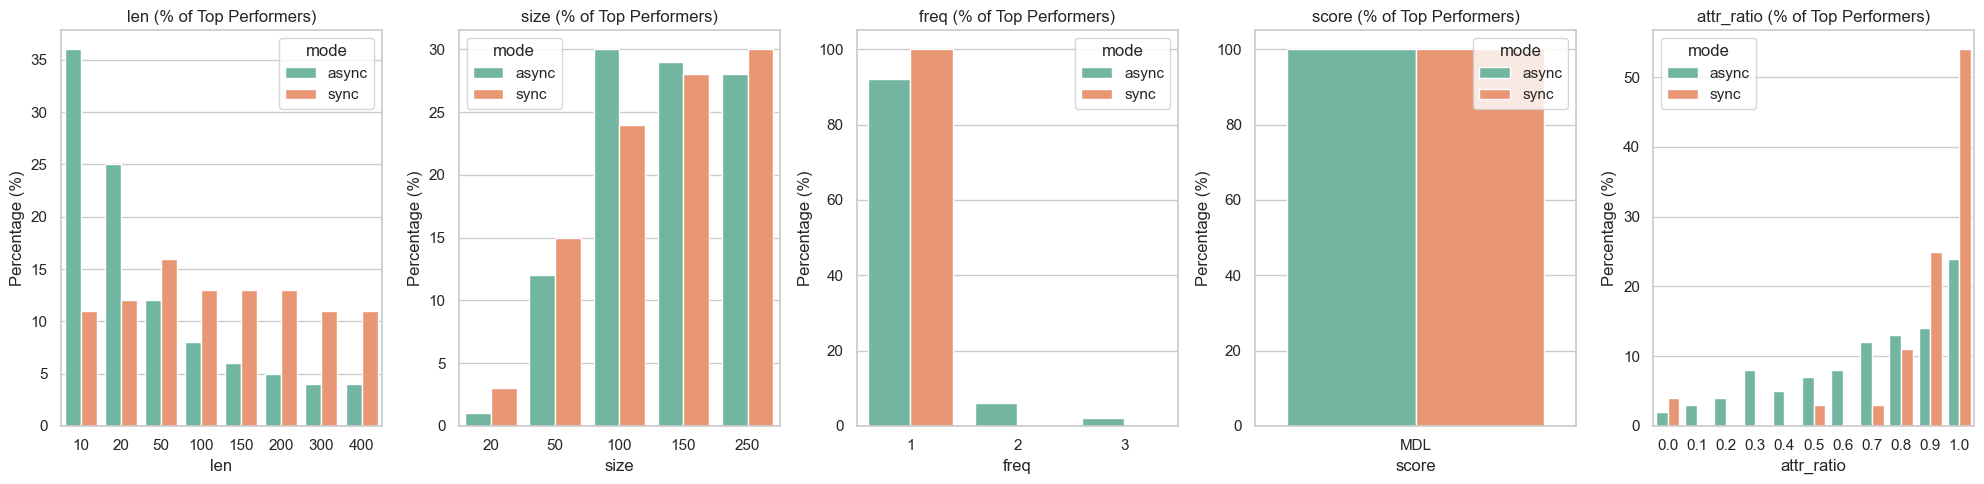


Dimension 7: Analyzed 200 Top Performers (Top 10% per Dim/Mode)


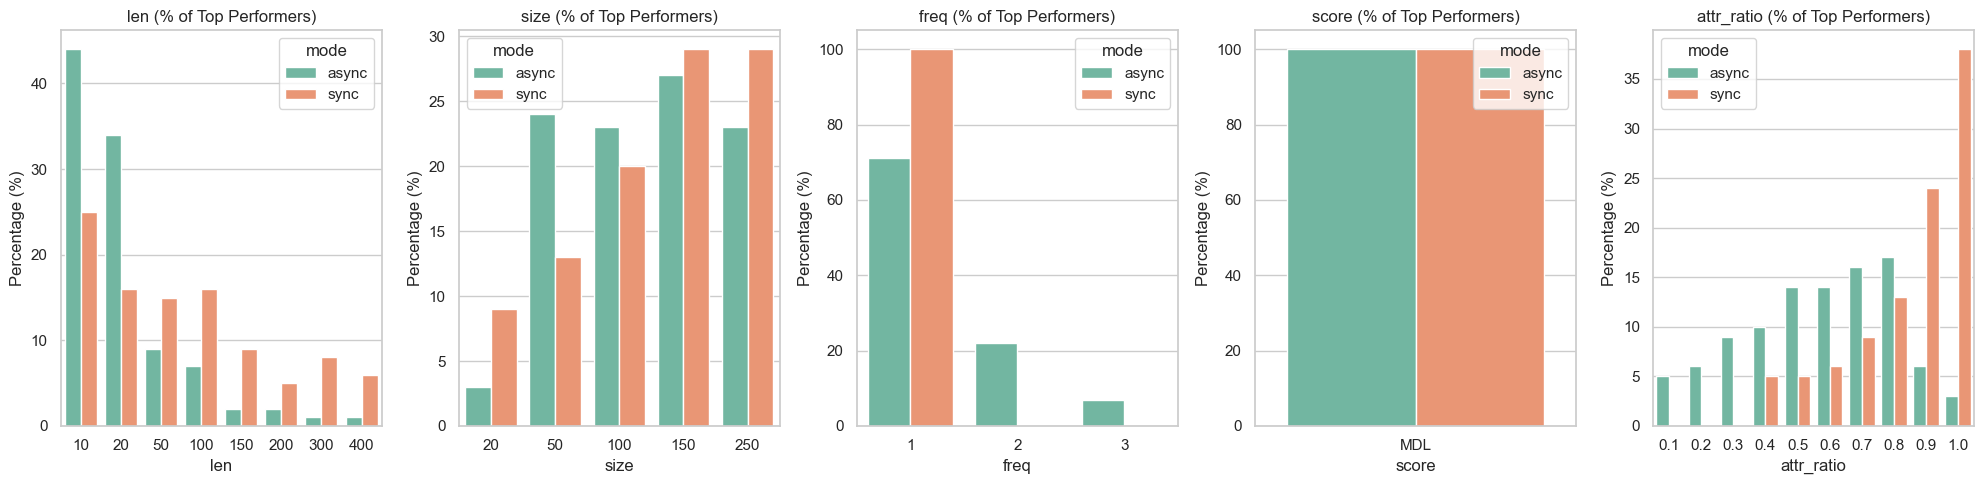


Dimension 8: Analyzed 200 Top Performers (Top 10% per Dim/Mode)


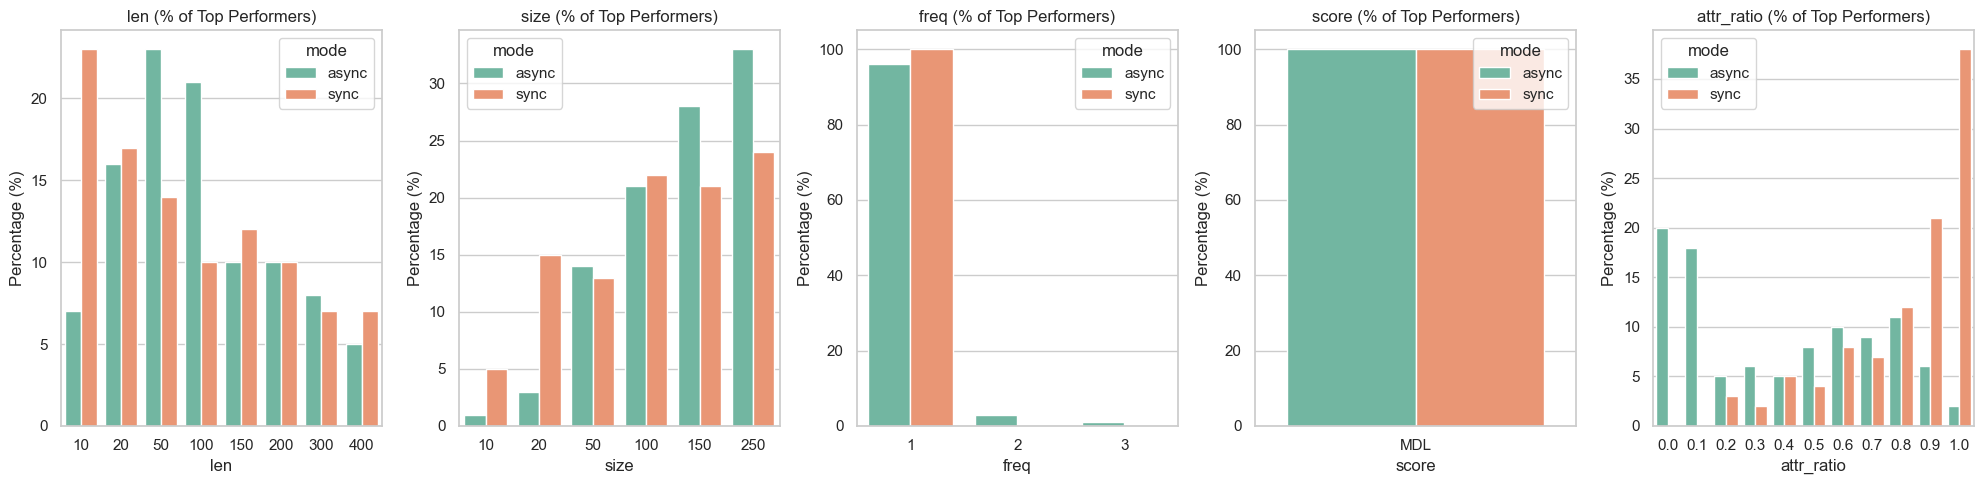


Dimension 9: Analyzed 200 Top Performers (Top 10% per Dim/Mode)


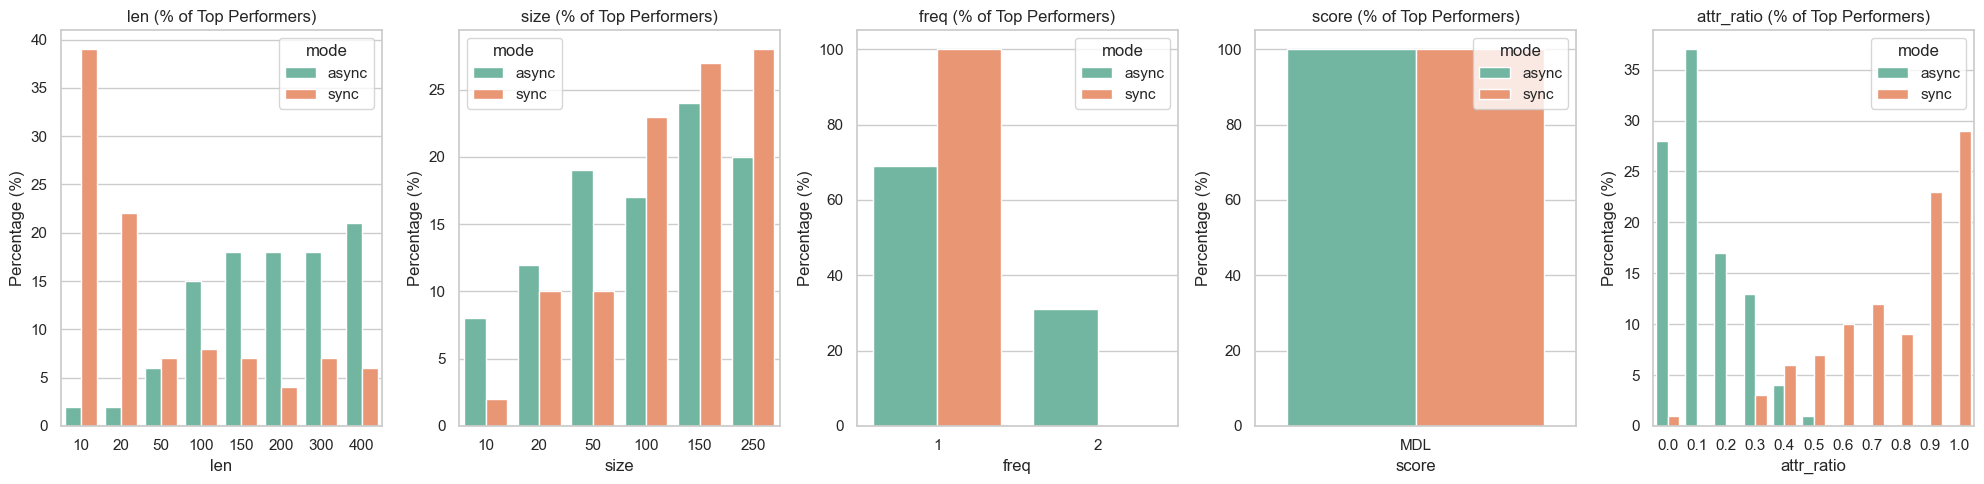


Dimension 10: Analyzed 200 Top Performers (Top 10% per Dim/Mode)


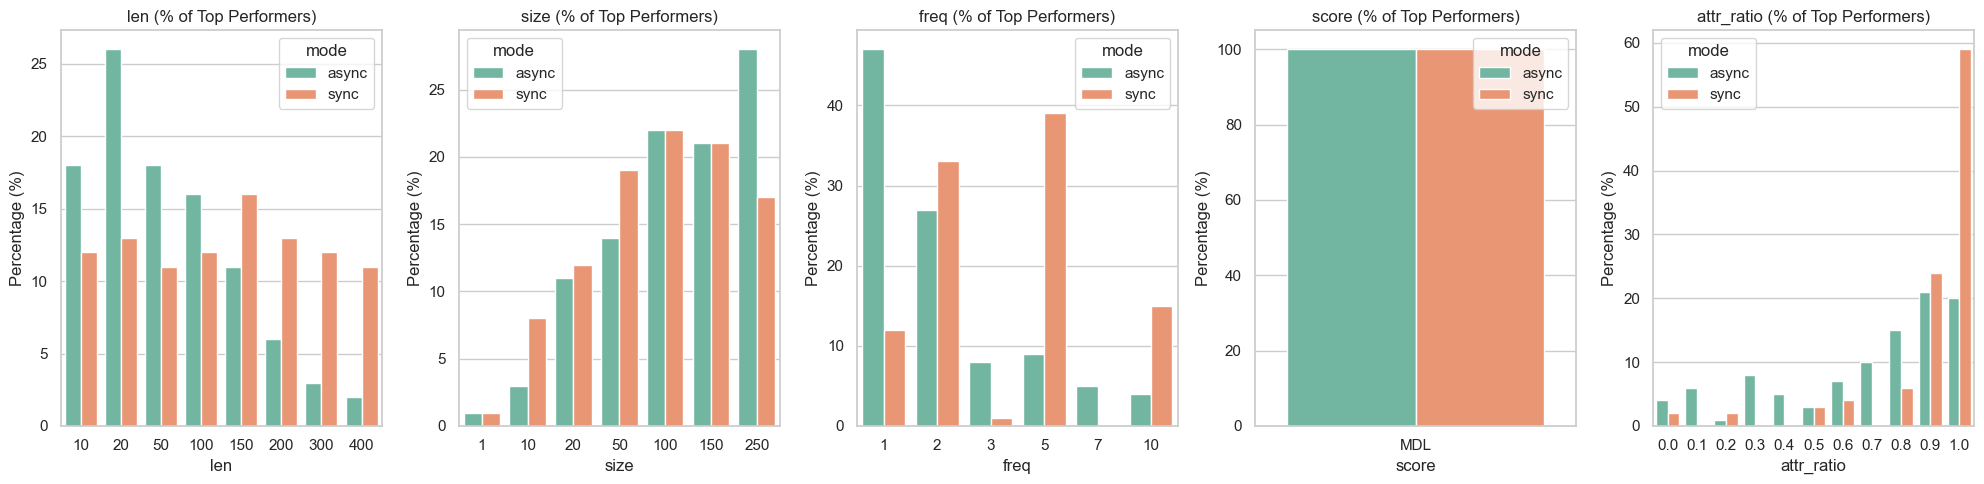

In [43]:
def plot_top_performers_characteristics(data, top_percentile=0.10, metric="F1", title_prefix="Overall"):
    """
    Selects top performers and plots normalized distributions of parameters.
    """
    # Select top performers per group (Dim, Mode) to handle different baselines
    # Actually, the user asked to "split by mode". Selecting top % globally might bias towards easier dimensions.
    # Selecting top % per dimension/mode is fairer.
    
    top_performers_list = []
    
    # Group by Dim and Mode to get top N from each
    for (d, m), group in data.groupby(["dim", "mode"]):
       
        top_subset = group.nlargest(100, metric)
        top_performers_list.append(top_subset)
        
    if not top_performers_list:
        return
        
    top_df = pd.concat(top_performers_list)
    
    print(f"\n{title_prefix}: Analyzed {len(top_df)} Top Performers (Top {top_percentile*100:.0f}% per Dim/Mode)")
    
    # Parameters to visualize
    viz_params = ["len", "size", "freq", "score", "attr_ratio"]
    
    # Set up subplots
    fig, axes = plt.subplots(1, len(viz_params), figsize=(4 * len(viz_params), 5))
    
    for i, param in enumerate(viz_params):
        # Calculate normalized counts (percentages) within each mode
        # We want: for Mode=Async, what % of top performers have len=10?
        
        counts = top_df.groupby(["mode", param]).size().reset_index(name="count")
        # Calculate total per mode
        mode_totals = top_df.groupby("mode").size().reset_index(name="total")
        
        counts = counts.merge(mode_totals, on="mode")
        counts["percentage"] = counts["count"] / counts["total"] * 100
        
        sns.barplot(data=counts, x=param, y="percentage", hue="mode", ax=axes[i], palette="Set2")
        axes[i].set_title(f"{param} (% of Top Performers)")
        axes[i].set_ylabel("Percentage (%)")
        
    plt.tight_layout()
    plt.show()

if not df.empty:
    # 1. Overall Aggregated Plot
    plot_top_performers_characteristics(df, title_prefix="All Dimensions Aggregated")
    
    # 2. Per-Dimension Plots
    dims = sorted(df["dim"].unique())
    for d in dims:
        dim_data = df[df["dim"] == d]
        plot_top_performers_characteristics(dim_data, title_prefix=f"Dimension {d}")

## 5. Parameter Importance Heatmaps

Average F1 score for combinations of Scoring Method and Mode for each dimension.

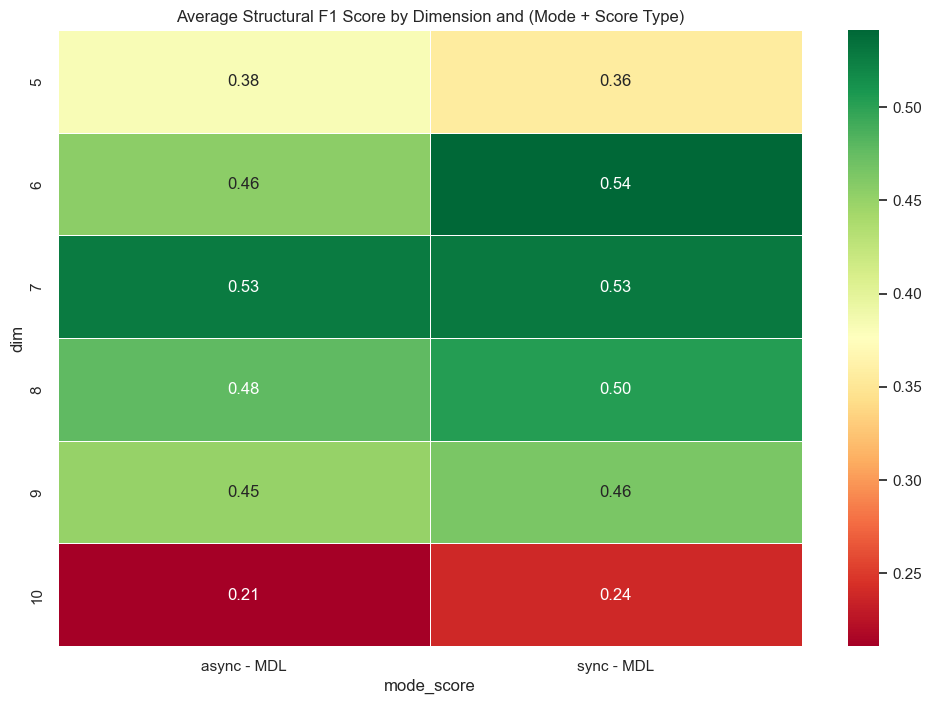

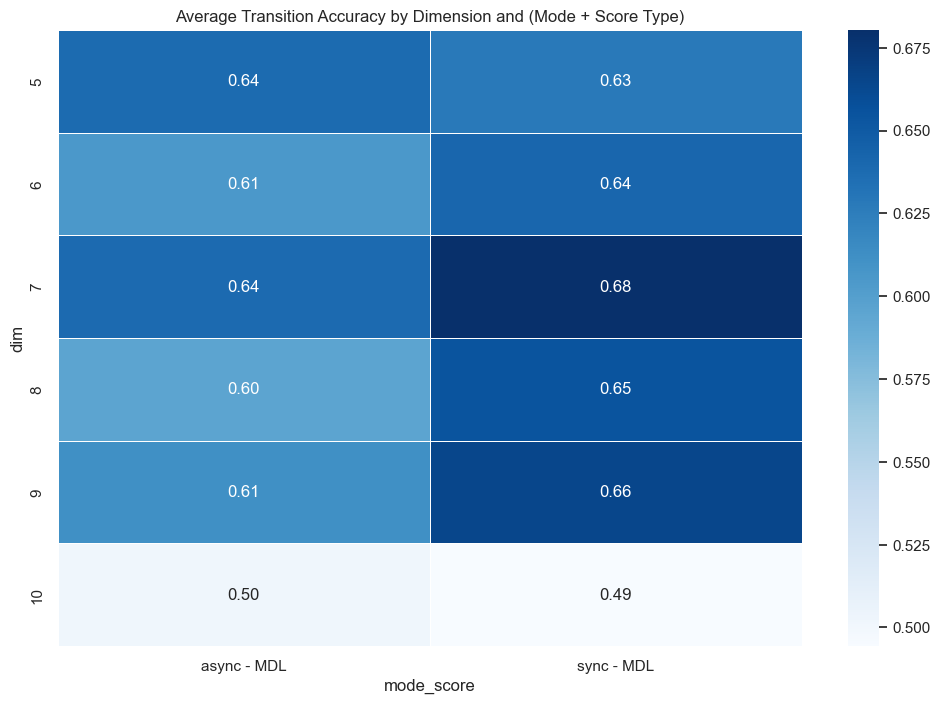

In [42]:
if not df.empty:
    # Pivot table for heatmap: Dim vs (Mode, Score)
    # We want rows=Dim, Cols=Mode+Score combination
    
    df["mode_score"] = df["mode"] + " - " + df["score"]
    
    pivot = pd.pivot_table(df, values="F1", index="dim", columns="mode_score", aggfunc="mean")
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, annot=True, cmap="RdYlGn", fmt=".2f", linewidths=.5)
    plt.title("Average Structural F1 Score by Dimension and (Mode + Score Type)")
    plt.show()
    
    # Also for Transition Accuracy
    pivot_trans = pd.pivot_table(df, values="Transition_Accuracy", index="dim", columns="mode_score", aggfunc="mean")
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_trans, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)
    plt.title("Average Transition Accuracy by Dimension and (Mode + Score Type)")
    plt.show()